In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader,ConcatDataset
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.optim import Adam

In [3]:
seed=42
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [4]:
transform_data=v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True)])
train_ds=datasets.CIFAR10(root='data',transform=transform_data)
test_ds=datasets.CIFAR10(root='data',train=False,transform=transform_data)
ds=ConcatDataset([train_ds,test_ds])

In [35]:
batch_size=128
ds_loader=DataLoader(ds,batch_size=batch_size,shuffle=True,drop_last=True)

In [79]:
imgs=next(iter(ds_loader))

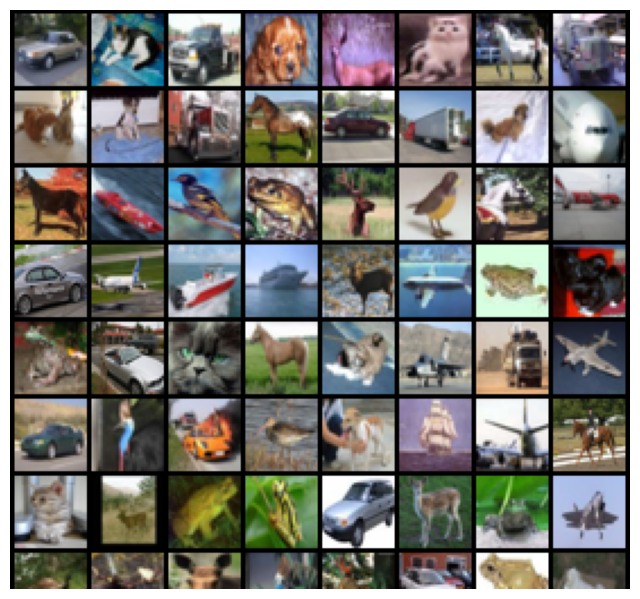

In [7]:
plt.figure(figsize=(8,20))
plt.imshow(make_grid(imgs[0]).permute(1,2,0)[:256])
plt.axis('off')
plt.show()

In [8]:
imgs[0].shape

torch.Size([128, 3, 32, 32])

In [9]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class Generator(nn.Module):
    def __init__(self,dim,n_channels,img_size):
        super().__init__()
        self.dim=dim
        self.net=nn.Sequential(
            #Input Z = (N,dim,1,1)  --> (N,img_size*4,4,4)
            nn.ConvTranspose2d(dim,img_size*4,4,1,0,bias=False),
            nn.BatchNorm2d(img_size*4),
            nn.LeakyReLU(),
            # -->  (N,img_size*2,8,8)
            nn.ConvTranspose2d(img_size*4,img_size*2,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(),
             # --> (N,img_size,16,16)
            nn.ConvTranspose2d(img_size*2,img_size,4,2,1,bias=False),
            nn.BatchNorm2d(img_size),
            nn.LeakyReLU(),
            # --> (N,n_channels,32,32)
            nn.ConvTranspose2d(img_size,n_channels,4,2,1,bias=False),
            nn.Tanh(),
        )
    def forward(self,x):
        return self.net(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self,n_channels,img_size):
        super().__init__()
        self.net=nn.Sequential(
            #Input (N,3,32,32) --> (N,img_size,img_size/2,img_size/2)
            nn.Conv2d(n_channels,img_size,4,2,1,bias=False),
            nn.BatchNorm2d(img_size),
            nn.LeakyReLU(),
            # --> (N,img_size*2,img_size/4,img_size/4)
            nn.Conv2d(img_size,img_size*2,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(),
            # --> (N,img_size*4,img_size/8,img_size/8)
            nn.Conv2d(img_size*2,img_size*4,4,2,1,bias=False),
            nn.BatchNorm2d(img_size*4),
            nn.LeakyReLU(),
            # --> (N,1,1,1)
            nn.Conv2d(img_size*4,1,4,1,0,bias=False),
            nn.Sigmoid(),
        )
    def forward(self,x):
        return self.net(x)

In [12]:
def weight_init(mod):
    name=mod.__class__.__name__
    if 'Conv' in name:
        nn.init.normal_(mod.weight.data,0.,0.02)
    elif 'BatchNorm' in name:
        nn.init.normal_(mod.weight.data,1.,0.02)
        nn.init.constant_(mod.bias.data,0.)

In [71]:
dim,n_channels,img_size=100,3,32
gen=Generator(dim,n_channels,img_size).to(device)
dis=Discriminator(n_channels,img_size).to(device)
gen.apply(weight_init)
dis.apply(weight_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)

In [72]:
lr=0.0002
beta1=0.5
epochs=100
loss=nn.BCELoss()
real_label=1.
fake_label=0.
noise=torch.randn(64,dim,1,1,device=device)
g_optim=Adam(gen.parameters(),lr=lr,betas=(beta1,0.999))
d_optim=Adam(dis.parameters(),lr=lr,betas=(beta1,0.999))

In [73]:
print('Training DCGAN')
g_loss=[]
d_loss=[]
gen_imgs=[]
for epoch in range(epochs):
    for idx,(imgs,_) in enumerate(ds_loader):
        dis.zero_grad()
        labels=torch.full((batch_size,),real_label,device=device)
        input=imgs.to(device)
        real_pred=dis(input).view(-1)
        real_loss=loss(real_pred,labels)
        real_loss.backward()
        d_x=real_pred.mean().item()
        labels.fill_(fake_label)
        z=torch.randn(batch_size,dim,1,1,device=device)
        fake_imgs=gen(z)
        fake_pred=dis(fake_imgs).view(-1)
        fake_loss=loss(fake_pred,labels)
        fake_loss.backward()
        d_z1=fake_pred.mean().item()
        t_loss=(real_loss+fake_loss).item()/2
        d_optim.step()

        gen.zero_grad()
        labels.fill_(real_label)
        real_z_pred=dis(fake_imgs.detach()).view(-1)
        real_z_loss=loss(real_z_pred,labels)
        real_z_loss.backward()
        d_z2=real_z_pred.mean().item()
        g_optim.step()
        d_loss.append(t_loss)
        g_loss.append(real_z_loss.item())
    #d_x:=D(x) should increase
    #D(z(x):=d_z1/d_z2 should increase decrease
    print(f'Epoch: {epoch}\tD_loss: {sum(d_loss)/len(d_loss):.4f}\tG_loss: {sum(g_loss)/len(g_loss):.4f}\tD(x): {d_x:.4f}\tD(z(x)): {d_z1/d_z2:.4f}')
    if epoch%20==0:
        with torch.no_grad():
            gen_imgs.append(gen(noise).detach().cpu())

Training DCGAN
Epoch: 0	D_loss: 0.0079	G_loss: 8.0167	D(x): 0.9999	D(z(x)): 1.0036
Epoch: 1	D_loss: 0.0040	G_loss: 9.1756	D(x): 1.0000	D(z(x)): 1.0019
Epoch: 2	D_loss: 0.0027	G_loss: 9.8659	D(x): 1.0000	D(z(x)): 1.0012
Epoch: 3	D_loss: 0.0020	G_loss: 10.3671	D(x): 1.0000	D(z(x)): 1.0010
Epoch: 4	D_loss: 0.0016	G_loss: 10.7667	D(x): 1.0000	D(z(x)): 1.0010
Epoch: 5	D_loss: 0.0013	G_loss: 11.1028	D(x): 1.0000	D(z(x)): 1.0008
Epoch: 6	D_loss: 0.0011	G_loss: 11.3956	D(x): 1.0000	D(z(x)): 1.0007
Epoch: 7	D_loss: 0.0010	G_loss: 11.6563	D(x): 1.0000	D(z(x)): 1.0006
Epoch: 8	D_loss: 0.0009	G_loss: 11.8941	D(x): 1.0000	D(z(x)): 1.0007
Epoch: 9	D_loss: 0.0008	G_loss: 12.1139	D(x): 1.0000	D(z(x)): 1.0006
Epoch: 10	D_loss: 0.0007	G_loss: 12.3193	D(x): 1.0000	D(z(x)): 1.0006
Epoch: 11	D_loss: 0.0007	G_loss: 12.5136	D(x): 1.0000	D(z(x)): 1.0006
Epoch: 12	D_loss: 0.0006	G_loss: 12.6986	D(x): 1.0000	D(z(x)): 1.0006
Epoch: 13	D_loss: 0.0006	G_loss: 12.8758	D(x): 1.0000	D(z(x)): 1.0005
Epoch: 14	D_loss: 

KeyboardInterrupt: 

In [102]:
img=gen(noise)
img=(img+1)/2

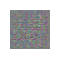

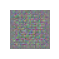

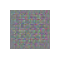

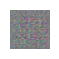

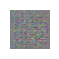

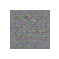

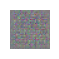

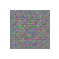

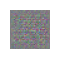

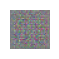

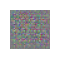

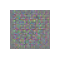

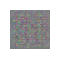

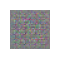

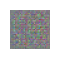

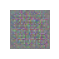

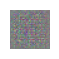

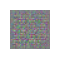

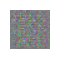

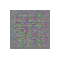

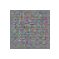

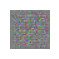

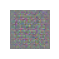

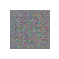

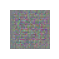

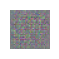

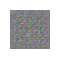

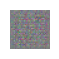

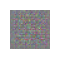

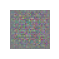

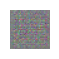

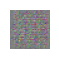

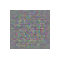

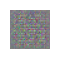

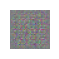

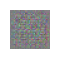

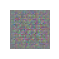

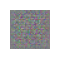

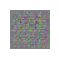

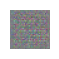

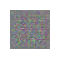

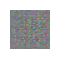

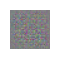

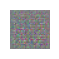

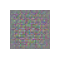

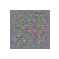

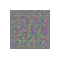

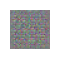

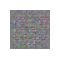

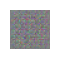

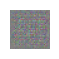

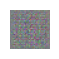

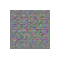

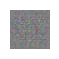

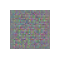

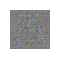

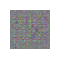

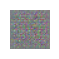

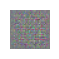

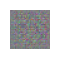

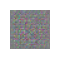

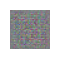

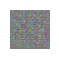

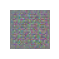

In [103]:
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(img[i].detach().permute(1,2,0))
    plt.axis('off')
    plt.show()